#### Aluno: Weld Lucas Cunha

Esse trabalho tem como base o código fornecido em aula pelo professor Samuel.

## 1. Set up

#### Imports

In [1]:
from copy import deepcopy
from typing import Tuple

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.datasets import make_blobs
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

#### Creating fake data

In [2]:
# fake data for testing
X, y = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.5, random_state=42)

print(X.shape)
print(y.shape)
print(f'Labels: {np.unique(y)}')

(1000, 2)
(1000,)
Labels: [0 1 2 3]


In [3]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (800, 2)
y_train.shape = (800,)
X_test.shape = (200, 2)
y_test.shape = (200,)


In [4]:
print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')

print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (800, 2)
y_train.shape = (800,)
X_test.shape = (200, 2)
y_test.shape = (200,)


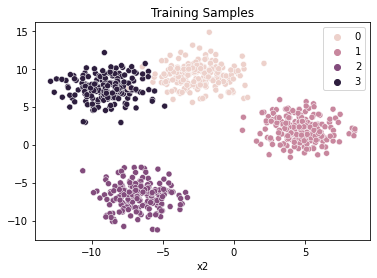

In [5]:
def plot_scatter(X_array, y_array, title=''):
    plt.title(title)
    sns.scatterplot(x=X_array[:, 0], y=X_array[:, 1], hue=y_array)
    plt.xlabel('x1')
    plt.xlabel('x2')    
    plt.show()

plot_scatter(X_train, y_train, title='Training Samples')

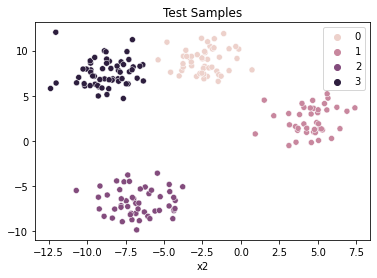

In [6]:
plot_scatter(X_test, y_test, title='Test Samples')

## 2. Implementation

In [7]:
class LogisticRegression(ClassifierMixin, BaseEstimator):
    """Our Logistic Regression implemented from scratch."""
    
    def __init__(self, learning_rate : float = 0.001,
                 n_epochs : int = 1000, alpha: float = 0.0001, random_state : int = 42):
        """
        Parameters
        ----------
        learning_rate : float, default=0.001
            Learning rate.
        n_epochs : int, default=1000
            Number of epochs for training (convergence stop).
        alpha : float, default=0.0001
            Constant that multiplies the regularization term.
            Use 0 to ignore regularization (standard Logistic Regression).
        random_state : int, default=42
            Seed used for generating random numbers.
        """
        assert (learning_rate is not None) and (learning_rate > 0.0), \
        f'Learning rate must be > 0. Passed: {learning_rate}'
        
        assert (n_epochs is not None) and (n_epochs > 0), \
        f'Number of epochs must be > 0. Passed: {n_epochs}'
        
        assert (alpha is not None) and (alpha >= 0), \
        f'Alpha should be >= 0. Passed: {alpha}'
        
        # public ==> todo mundo tem acesso para leitura e escrita direta
        # private ==> apenas a classe tem acesso para leitura e escrita direta
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.alpha = alpha
        self.random_state = random_state
        
        # parameters to be trained/learned
        self.classes_ = []
        self.__indexes_dict = {}
        self.__w = None  # weight array
        self.__b = None  # bias
        self.__w_dict = {}
        self.__b_dict = {}
        
    
    # a special method used to represent a class object as a string, called with print() or str()
    def __str__(self):
        msg = f'Learning rate: {self.learning_rate}\n' \
              f'Number of epochs: {self.n_epochs}\n' \
              f'Regularization constant (alpha): {self.alpha}\n' \
              f'Random state: {self.random_state}\n\n' \
              f'Trained?: {self.is_fitted()}\n'
        return msg
    
    
    # getter: access the function as an attribute - it is not possible to set values through it
    @property
    def coef_(self) -> ndarray:
        """Return the weight matrix (learned parameters) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__w_dict
    
    
    # getter: access the function as an attribute - it is not possible to set values through it
    @property
    def intercept_(self) -> float:
        """Return the bias (learned intercepet) if the estimator was fitted/trained.
           Otherwise, raise an exception.
        """
        assert self.is_fitted(), 'The instance is not fitted yet.'
        return self.__b
    
    
    def is_fitted(self) -> bool:
        return self.__w is not None
    
    
    def __sigmoid(self, z: ndarray) -> ndarray:
        return 1 / (1 + np.e ** (-z))
    
    
    def __log_loss(self, y: ndarray, p_hat: ndarray, eps: float = 1e-15):
        '''Return the log loss for a given estimation and ground-truth (true labels).
        
        log is undefined for 0. Consequently, the log loss is undefined for `p_hat=0` (because of log(p_hat)) and `p_hat=1` (because of ln(1 - p_hat)).
        To overcome that, we clipped the probabilities to max(eps, min(1 - eps, p_hat)), where `eps` is a tiny constant.
        Parameters
        ----------
        y : ndarray, shape (n_samples,)
            True labels of input samples.
        p_hat : ndarray
            Estimated probabilities of input samples.
        eps : float, default=1e-15
            Epsilon term used to avoid undefined log loss at 0 and 1.
        
        Returns
        -------
        log_loss : float
            Computed log loss.
        '''
        
        p_hat_eps = np.maximum(eps, np.minimum(1 - eps, p_hat))
        
        # shape: (n_samples,)
        losses = -(y * np.log(p_hat_eps) + (1 - y) * np.log(1 - p_hat_eps))
        log_loss = losses.mean()
        
        return log_loss
    
    
    def __gradient(self, X: ndarray, y: ndarray, p_hat: ndarray,
                   w: ndarray, alpha: float) -> Tuple[ndarray, float]:
        '''Compute the gradient vector for the log loss with regards to the weights and bias.
        
        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        p_hat : ndarray, shape (n_samples,)
            Estimated probabilities.
        w : ndarray, shape (n_features,)
            Weight array.
        alpha : float
            Reguralization constant.
        
        Returns
        -------
        Tuple[ndarray, float]: 
            Tuple with:
            - a numpy array of shape (n_features,) containing the partial derivatives w.r.t. the weights; and
            - a float representing the partial derivative w.r.t. the bias.
        '''
        # X.shape: (n_samples, n_features)
        # y.shape == p_hat.shape: (n_samples,)
        n_samples = X.shape[0]
        
        regularization = alpha * w
        
        error = p_hat - y  # shape (n_samples,)
        grad_w = (np.dot(error, X) / n_samples) + regularization  # shape (n_features,)
        grad_b = error.mean()  # float
        
        return grad_w, grad_b

    def fit(self, X: ndarray, y: ndarray, verbose: int = 0):
        for i,val in enumerate(np.unique(y)):
            self.classes_.append(val)
            self.__indexes_dict[val] = i
            y_copy = np.zeros(y.shape)
            y_copy[y == val] = 1
            self.__fit(X, y_copy, verbose=verbose)
            self.__w_dict[i] = self.__w
            self.__b_dict[i] = self.__b
        
    def __fit(self, X: ndarray, y: ndarray, verbose: int = 0):
        '''Train a Logistic Regression classifier.
        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Training data.
        y: ndarray of shape (n_samples,).
            Target (true) labels.
        verbose: int, default=0
            Verbose flag. Print training information every `verbose` iterations.
            
        Returns
        -------
        self : object
            Returns self.
        '''
        ### CHECK INPUT ARRAY DIMENSIONS
        assert X.ndim == 2, f'X must be 2D. Passed: {X.ndim}'
        assert y.ndim == 1, f'y must be 1D. Passed: {y.ndim}'
        assert X.shape[0] == y.shape[0], \
            f'X.shape[0] should be equal to y.shape[0], instead: {X.shape[0]} != {y.shape[0]}'
        # alternatively
        # X, y = check_X_y(X, y)

        ### SETTING SEED
        np.random.seed(self.random_state)
        
        n_samples, n_features = X.shape

        ### PARAMETER INITIALIZATION
        # return values from the “standard normal” distribution.
        w = np.random.randn(n_features)  # shape: (n_features,)
        b = 0.0
        
        # array that stores the loss of each epoch
        losses = []
        
        # import pdb
        # pdb.set_trace()  # break point
        
        
        # LEARNING ITERATIONS
        for epoch in np.arange(self.n_epochs):
            ### ESTIMATION (FORWARD PASS)
            # X.shape == (n_samples, n_features)
            # w.shape == (n_features,)
            z = np.dot(X, w) + b  # shape: (n_samples,)
            p_hat = self.__sigmoid(z)
            
            loss_epoch = self.__log_loss(y, p_hat)
            losses.append(loss_epoch)
            
            ### GRADIENT DESCENT UPDATES (BACKWARD PASS)
            # grad_w.shape: (n_features,)
            # grad_b: float
            grad_w, grad_b = self.__gradient(X, y, p_hat, w, self.alpha)
            w = w - self.learning_rate * grad_w  # shape: (n_features)
            b = b - self.learning_rate * grad_b  # float
            
            # pdb.set_trace()
            
            if verbose and (epoch == 0 or (epoch + 1) % verbose == 0):
                print(f'[INFO] epoch={epoch + 1}/{self.n_epochs}, loss={loss_epoch:.7f}')
                
                ## code snippet to save the intermediate decision boundaries each `verbose` iterations
                w1, w2 = w
                x1_decision_line = np.array([X[:,0].min(), X[:,0].max()])
                x2_decision_line = -(b + (w1 * x1_decision_line)) / w2
                ax = sns.scatterplot(x=X[:, 0], y=X[:,1], hue=y)
                sns.lineplot(x=x1_decision_line, y=x2_decision_line, color='lightseagreen', ax=ax)
                ax.set_xlabel('x1')
                ax.set_ylabel('x2')
                ax.set_xlim(X[:,0].min(), X[:,0].max())
                ax.set_ylim(X[:,1].min(), X[:,1].max())
                ax.set_title('Decision Boundary on Training Samples')
                fig = ax.get_figure()
                fig.savefig(f'./plots/decision_boundary_epoch_{epoch+1:08d}.png')
                plt.close(fig)  # to avoid showing the plot on jupyter
        
        if verbose:
            losses = np.array(losses)
            print(f'\nFinal loss: {losses[-1]}')
            print(f'\nMean loss: {losses.mean()} +- {losses.std()}')

        ### ASSIGN THE TRAINED PARAMETERS TO THE PRIVATE ATTRIBUTES
        self.__w = w
        self.__b = b

    def __predict_proba(self, X: ndarray, w, b) -> ndarray:
        '''Estimate the probability for the positive class of input samples.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            The estimated probabilities for the positive class of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must b 2D. Passed: {X.ndim}'

        z = np.dot(X, w) + b
        p_hat = self.__sigmoid(z)
        
        return p_hat

    def predict_proba(self, X: ndarray) -> ndarray:
        '''Estimate the probability for the positive class of input samples.

        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            The estimated probabilities for the positive class of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must b 2D. Passed: {X.ndim}'

        p_hat_dict = {}
        for i,class_name in self.__indexes_dict.items():
            p_hat = self.__predict_proba(X, self.__w_dict[i], self.__b_dict[i])
            p_hat_dict[i] = p_hat
        p_hat_df = pd.DataFrame(p_hat_dict)
        y_prob = np.array([max(p_hat_df.loc[idx, :]) for idx in p_hat_df.index], dtype=float)
        return y_prob

    def predict(self, X: ndarray) -> ndarray:
        '''Predict the labels for input samples.
        Parameters
        ----------
        X: ndarray of shape (n_samples, n_features)
            Input samples.
            
        Returns
        -------
        ndarray of shape (n_samples,)
            Predicted labels of input samples.
        '''
        assert self.is_fitted(), 'The instance is not fitted yet.'
        assert X.ndim == 2, f'X must b 2D. Passed: {X.ndim}'

        p_hat_dict = {}
        for i,class_name in self.__indexes_dict.items():
            p_hat = self.__predict_proba(X, self.__w_dict[i], self.__b_dict[i])
            p_hat_dict[i] = p_hat
        p_hat_df = pd.DataFrame(p_hat_dict)
        y_hat = np.array([self.classes_[np.argmax(p_hat_df.loc[idx, :])] for idx in p_hat_df.index], dtype=int)
        return y_hat

Foi implementada a estratégia one vs rest.
Nesta estratégia são treinados N classificadores binários, onde N é o número de classes presentes no dataset.

Essa abordagem requer que cada modelo preveja uma probabilidade de associação de classe ou uma pontuação 
semelhante à probabilidade. O argmax dessas pontuações (índice de classe com a maior pontuação) é então usado 
para prever uma classe.

In [8]:
clf = LogisticRegression()
clf

LogisticRegression()

In [9]:
print(clf)

Learning rate: 0.001
Number of epochs: 1000
Regularization constant (alpha): 0.0001
Random state: 42

Trained?: False



#### **Testing `fit()`**

In [10]:
# L2 regularization - alpha=100
clf = LogisticRegression(alpha=100)
clf.fit(X_train, y_train)
clf.coef_

{0: array([0.00739051, 0.00881894]),
 1: array([ 0.02433   , -0.00676488]),
 2: array([-0.00231138, -0.02670888]),
 3: array([-0.0065807 ,  0.00431483])}

Aqui temos coef_ como um dicionario que contém diversos vetores/arrays.
Um para cada classe, onde esta classe é considerada a classe positiva (ou classe 1) e o resto a clase negativa (ou classe zero).

In [11]:
print(clf)

Learning rate: 0.001
Number of epochs: 1000
Regularization constant (alpha): 100
Random state: 42

Trained?: True



### Prediction

In [12]:
y_test_prob = clf.predict_proba(X_test)
y_test_prob

array([0.47409219, 0.46242621, 0.50457997, 0.4737065 , 0.4678898 ,
       0.46636472, 0.50846764, 0.46166893, 0.50403969, 0.46360868,
       0.45820408, 0.47970154, 0.4668075 , 0.46513186, 0.46748508,
       0.46045944, 0.4629722 , 0.47544673, 0.46542475, 0.46173071,
       0.46221837, 0.45750718, 0.45772585, 0.49491591, 0.48858815,
       0.48268906, 0.46694989, 0.46816814, 0.47194886, 0.45987544,
       0.46074422, 0.476009  , 0.47500157, 0.46845686, 0.48492409,
       0.49893926, 0.48387606, 0.4651031 , 0.45991636, 0.4927566 ,
       0.45741569, 0.46247902, 0.4673067 , 0.49086304, 0.45963007,
       0.46469914, 0.46708697, 0.45855165, 0.45651636, 0.46720025,
       0.48034911, 0.45661335, 0.46161976, 0.4753206 , 0.46851203,
       0.4861022 , 0.46948193, 0.48228624, 0.4672067 , 0.50608473,
       0.49344277, 0.45927418, 0.46223231, 0.49537182, 0.50592074,
       0.46117906, 0.46984897, 0.46204583, 0.46207431, 0.45760145,
       0.45920577, 0.46410664, 0.46677068, 0.46597734, 0.49516

In [13]:
y_test_pred = clf.predict(X_test)
y_test_pred

array([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0,
       1, 2, 2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2,
       0, 3, 1, 0, 0, 3, 1, 3, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0,
       0, 3, 3, 0, 0, 3, 3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3,
       3, 2, 3, 3, 1, 3, 3, 3, 1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 3, 3, 2,
       1, 1, 0, 2, 2, 3, 0, 0, 1, 2, 2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2,
       3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2, 0, 3, 3, 2, 2, 1, 3, 2,
       3, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0, 2, 2, 2, 0, 3, 1, 1, 1,
       1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 3, 1, 2, 2, 0, 3, 1, 3, 2, 0, 3, 1,
       2, 1])

In [14]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94        49
           1       1.00      0.98      0.99        41
           2       1.00      1.00      1.00        53
           3       0.92      1.00      0.96        57

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



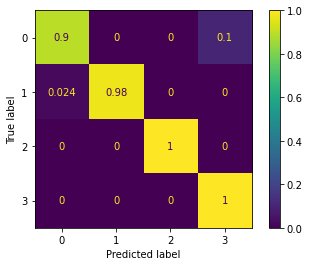

In [15]:
plot_confusion_matrix(clf, X_test, y_test, normalize='true')

# Validating the implementation on Wine Dataset

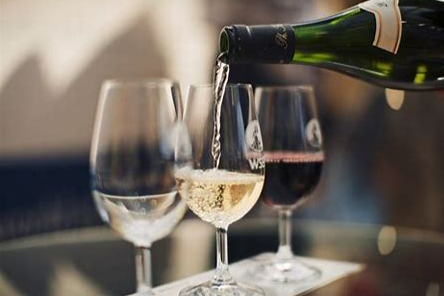

In [16]:
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [17]:
wine = load_wine()
X = wine['data']
y = wine['target']

In [18]:
print(X.shape)
print(y.shape)
print(f'Labels: {np.unique(y)}')

(178, 13)
(178,)
Labels: [0 1 2]


In [19]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (142, 13)
y_train.shape = (142,)
X_test.shape = (36, 13)
y_test.shape = (36,)


## Data Exploration

In [20]:
df = pd.DataFrame(X_train, columns=wine['feature_names'])
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.34,1.68,2.70,25.0,98.0,2.80,1.31,0.53,2.70,13.00,0.57,1.96,660.0
1,12.53,5.51,2.64,25.0,96.0,1.79,0.60,0.63,1.10,5.00,0.82,1.69,515.0
2,12.37,1.07,2.10,18.5,88.0,3.52,3.75,0.24,1.95,4.50,1.04,2.77,660.0
3,13.48,1.67,2.64,22.5,89.0,2.60,1.10,0.52,2.29,11.75,0.57,1.78,620.0
4,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,13.86,1.51,2.67,25.0,86.0,2.95,2.86,0.21,1.87,3.38,1.36,3.16,410.0
138,12.25,1.73,2.12,19.0,80.0,1.65,2.03,0.37,1.63,3.40,1.00,3.17,510.0
139,14.38,1.87,2.38,12.0,102.0,3.30,3.64,0.29,2.96,7.50,1.20,3.00,1547.0
140,12.69,1.53,2.26,20.7,80.0,1.38,1.46,0.58,1.62,3.05,0.96,2.06,495.0


In [21]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
alcohol,142.0,12.979085,0.820116,11.03,12.3325,13.010,13.6775,14.83
malic_acid,142.0,2.373521,1.143934,0.89,1.6150,1.875,3.1350,5.80
ash,142.0,2.360845,0.279217,1.36,2.2100,2.360,2.5400,3.23
alcalinity_of_ash,142.0,19.473239,3.454792,10.60,17.2000,19.200,21.5000,30.00
magnesium,142.0,100.443662,14.650793,70.00,88.2500,98.000,107.0000,162.00
total_phenols,142.0,2.289085,0.637715,0.98,1.7250,2.310,2.8000,3.88
flavanoids,142.0,2.002113,1.004170,0.34,1.1250,2.075,2.8425,5.08
nonflavanoid_phenols,142.0,0.368028,0.128269,0.13,0.2700,0.340,0.4700,0.66
proanthocyanins,142.0,1.608028,0.583656,0.42,1.2500,1.555,1.9675,3.58
color_intensity,142.0,5.057606,2.330917,1.74,3.2200,4.600,6.1225,13.00


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       142 non-null    float64
 1   malic_acid                    142 non-null    float64
 2   ash                           142 non-null    float64
 3   alcalinity_of_ash             142 non-null    float64
 4   magnesium                     142 non-null    float64
 5   total_phenols                 142 non-null    float64
 6   flavanoids                    142 non-null    float64
 7   nonflavanoid_phenols          142 non-null    float64
 8   proanthocyanins               142 non-null    float64
 9   color_intensity               142 non-null    float64
 10  hue                           142 non-null    float64
 11  od280/od315_of_diluted_wines  142 non-null    float64
 12  proline                       142 non-null    float64
dtypes: fl

## Preprocessing

In [23]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Components Analysis

In [24]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

tsne = TSNE(n_components=3)
X_tsne = tsne.fit_transform(X_train)

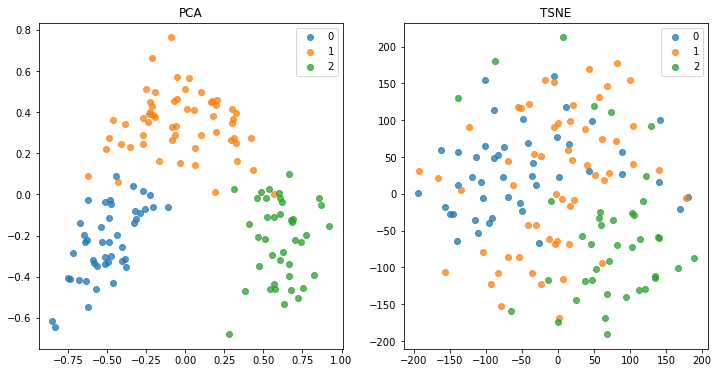

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title('PCA')
for y in np.unique(y_train):
    X_tmp = X_pca[y_train == y]
    plt.scatter(X_tmp[:, 0], X_tmp[:, 1], label=y, alpha=0.75)
plt.legend()
plt.subplot(1,2,2)          
plt.title('TSNE')
for y in np.unique(y_train):
    X_tmp = X_tsne[y_train == y]
    plt.scatter(X_tmp[:, 0], X_tmp[:, 1], label=y, alpha=0.75)
plt.legend()

plt.show()

Pode ser observado que, ao aplicar o PCA, as três classes são distintas umas das outras, podendo ser separadas quase que perfeitamente. Já a técnica TSNE não apresenta a mesma capacidada quando considerando-se apenas as 2 componentes mais relevantes.


## Baseline

In [26]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

In [27]:
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.61      1.00      0.76        14
           2       0.00      0.00      0.00         8

    accuracy                           0.75        36
   macro avg       0.54      0.64      0.57        36
weighted avg       0.63      0.75      0.67        36



C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weldl\Miniconda3\envs\work\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


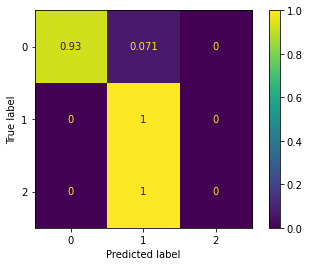

In [28]:
plot_confusion_matrix(clf, X_test, y_test, normalize='true')

O modelo base apresentou uma performance bastante ruim.
Este modelo foi treinado considerando os valores padrão da classe LogisticRegression. Na próxima seção será realizado o fine-tuning, visando obter melhores resultados no teste.

## Fine-Tuning

In [29]:
n_jobs = 4
n_iter = 100
cv = 5
scoring = 'balanced_accuracy'

In [30]:
# LogisticRegression:
param_grid = {'learning_rate': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
              'n_epochs': [1000, 5000, 1000, 2000],
              'alpha': [10, 1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
             }

logreg_clf = RandomizedSearchCV(LogisticRegression(), param_distributions=param_grid, n_iter=n_iter, cv=cv,
                             scoring=scoring, n_jobs=n_jobs, verbose=1, random_state=42)
logreg_clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100, n_jobs=4,
                   param_distributions={'alpha': [10, 1, 0.1, 0.01, 0.001,
                                                  0.0001, 1e-05],
                                        'learning_rate': [10, 1, 0.1, 0.01,
                                                          0.001, 0.0001,
                                                          1e-05],
                                        'n_epochs': [1000, 5000, 1000, 2000]},
                   random_state=42, scoring='balanced_accuracy', verbose=1)

In [31]:
model = logreg_clf.best_estimator_ 
model.fit(X_train, y_train)

In [32]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00         8

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



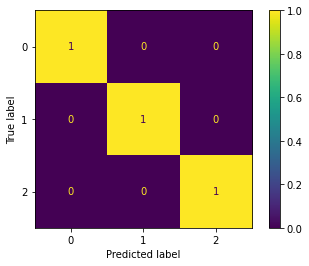

In [33]:
plot_confusion_matrix(model, X_test, y_test, normalize='true')

Após o fine-tuning pudemos notar que o modelo obteve uma melhoria significativa em relação ao baseline.
Este é um dataset relativamente simples e pequeno. Não era esperado um resultado perfeito na base de teste.

# Conclusion

Pudemos observar que a classe foi estendida para que pudesse lidar com problemas multiclasse, para isso foi escolhida a estratégia one vs all, devido a sua simplicidade e se adequar melhor para problemas de muitas classes, se comparado à estratégia one vs one.

Considerando o dataset de validação, wine dataset, tivemos um baseline bastante ruim, porém ao fazer o fine-tuning obtivemos um excelente resultado.

Não foram implementadas diferentes versões do gradiente descendente.